## Initial Setup

In [1]:
# Initial setup...
import numpy as np
import pandas as pd
from astropy.io import fits
import fitsio
from scipy import interpolate
import glob
import math
import os

import h5py
import bisect

import matplotlib.pyplot as plt

%matplotlib inline


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des17a/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## User input

In [2]:
# debug=True fits a single spectrum with a smaller set of models and over a smaller range of redshifts...
debug=False

# Kasen (2017) models directory name:
if not debug:
    kasen_dirname='/data/des40.a/data/dtucker/DESGW_analysis/Kasen_Kilonova_Models_2017/systematic_kilonova_model_grid'
else:
    kasen_dirname='/data/des40.a/data/dtucker/DESGW_analysis/Kasen_Kilonova_Models_2017/kilonova_models'

    
# Redshift and 1sigma error in redshift based on LIGO luminosity distance, 1sigma error in luminosity distance...
z = 0.059
if not debug:
    zerr = 0.011  # 1sigma error
else:
    zerr= 0.001   # debug redshift test range

    
# Directory name for the UCSC-processed spectra:
inputFile_obs_dirname = '/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_UCSC'

# Output directory...
output_dirname = 'cd /data/des40.a/data/dtucker/DESGW_analysis/S190814bv_analysis/FigOutput'


if not debug:
    
    inputFile_obs_list = ['2019noq.flm', 
                          'AT2019npw-3.flm', 
                          'AT2019ntp.flm', 
                          'AT2019num.flm', 
                          'desgw-190814c.flm', 
                          '2019ntn.flm', 
                          'AT2019ntr.flm', 
                          'desgw-190814d.flm']
#                          'AT2019omx.flm', 
#                          'AT2019nte.flm', 

    cleanName_obs_dict = {'2019noq.flm':'AT2019noq', 
                          'AT2019npw-3.flm':'AT2019npw', 
                          'AT2019ntp.flm':'AT2019ntp', 
                          'AT2019num.flm':'AT2019num', 
                          'desgw-190814c.flm':'AT2019nqq', 
                          '2019ntn.flm':'AT2019mbq', 
#                          '2019ntn.flm':'AT2019ntn', 
                          'AT2019ntr.flm':'AT2019ntr', 
                          'desgw-190814d.flm':'AT2019nqr'}
#                          'AT2019omx.flm':'AT2019omx', 
#                          'AT2019nte.flm', 

    # Time [in days] past the merger event when the spectrum was observed...
    t_dict = {'2019noq.flm': 6.49, 
              'AT2019npw-3.flm': 12.45, 
              'AT2019ntp.flm': 17.41, 
              'AT2019num.flm': 12.45, 
              'desgw-190814c.flm': 2.44, 
              '2019ntn.flm': 6.49, 
              'AT2019ntr.flm': 14.45, 
              'desgw-190814d.flm': 2.44}
#              'AT2019omx.flm': 14.45, 
#              'AT2019nte.flm': ???, 

else:
    inputFile_obs_list = ['2019noq.flm']
    cleanName_obs_dict = {'2019noq.flm':'AT2019noq'}
    t_dict = {'2019noq.flm': 6.49}
    

## Fitting function to Kasen (2017) models

In [3]:
def fit_to_kasen(kasen_dirname, wavelength_array, df_obs_new, t, z, zerr):

    names = glob.glob(kasen_dirname+'/knova_*.h5')

    bestSum2 = 9.999e+99
    bestName = ''
    c = 2.99e10   # speed of light in cm/sec...
    
    # Loop over all redshifts within the LIGO 1-sigma redshift limits
    # (based on of LIGO 1-sigma Dlum limits)...

    z_min=z-zerr
    if z_min <0.001:
        z_min=0.001
   
    z_max=z+zerr
    zs=np.arange(z_min,z_max+0.001,0.001)
 
    for z_test in zs:
        
        print z_test, 
        
        # Loop over all models at redshift z...
        for name in names:
        
            # open model file
            fin    = h5py.File(name,'r')

            # frequency in Hz
            nu    = np.array(fin['nu'],dtype='d')
            # array of time in seconds
            times = np.array(fin['time'])
            # covert time to days
            times = times/3600.0/24.0

            # specific luminosity (ergs/s/Hz)
            # this is a 2D array, Lnu[times][nu]
            Lnu_all   = np.array(fin['Lnu'],dtype='d')

            # index corresponding to t
            it = bisect.bisect(times,t)
            # spectrum at this epoch
            Lnu = Lnu_all[it,:]

            # if you want thing in Flambda (ergs/s/Angstrom)
            lam0  = c/nu*1e8
            lam   = lam0*(1+z_test)
            Llam = Lnu*nu**2.0/c/1e8

            df_model = pd.DataFrame({'LAMBDA0':lam0, 'LAMBDA':lam, 'Llam':Llam})

            spec_flux_model = interpolate.interp1d(df_model.LAMBDA, df_model.Llam,bounds_error=False, fill_value=0.,kind='linear')
            spec_flux_model_array = spec_flux_model(wavelength_array)

            df_model_new = pd.DataFrame({'LAMBDA':wavelength_array, 'Llam':spec_flux_model_array})

            norm = df_model_new['Llam'].median()

            df_model_new['normLlam'] = df_model_new['Llam']/norm

            merged = pd.merge(df_obs_new, df_model_new, on='LAMBDA')
        
            merged['delta_flux'] = merged['normFLUX'] - merged['normLlam']

            mask = ((merged.normFLUX.isnull()) | (merged.normLlam.isnull()))
            mask = (mask == False)
        
            if np.any(mask):
            
                sum2 = np.sum(np.square(merged[mask].delta_flux)) / np.sum(mask)

                if sum2 < bestSum2:
                    bestSum2 = sum2
                    bestName = name
                    bestz = z_test

       
    return bestName, bestSum2, bestz

## Plot function

In [4]:
def plot_obs_and_bestfit_model(obsname, obsname_clean, kasen_dirname, name, wavelength_array, df_obs_new, t, z, sum2, output_dirname):

    c = 2.99e10   # speed of light in cm/sec...

    basename = name
    name = kasen_dirname+'/'+basename

    fin    = h5py.File(name,'r')

    # frequency in Hz
    nu    = np.array(fin['nu'],dtype='d')
    # array of time in seconds
    times = np.array(fin['time'])
    # covert time to days
    times = times/3600.0/24.0

    # specific luminosity (ergs/s/Hz)
    # this is a 2D array, Lnu[times][nu]
    Lnu_all   = np.array(fin['Lnu'],dtype='d')

    # index corresponding to t
    it = bisect.bisect(times,t)
    # spectrum at this epoch
    Lnu = Lnu_all[it,:]

    # if you want thing in Flambda (ergs/s/Angstrom)
    lam0  = c/nu*1e8
    lam   = lam0*(1+z)
    Llam = Lnu*nu**2.0/c/1e8

    df_model = pd.DataFrame({'LAMBDA0':lam0, 'LAMBDA':lam, 'Llam':Llam})

    spec_flux_model = interpolate.interp1d(df_model.LAMBDA, df_model.Llam,bounds_error=False, fill_value=0.,kind='linear')
    spec_flux_model_array = spec_flux_model(wavelength_array)

    df_model_new = pd.DataFrame({'LAMBDA':wavelength_array, 'Llam':spec_flux_model_array})

    norm = df_model_new['Llam'].median()

    df_model_new['normLlam'] = df_model_new['Llam']/norm

    ax = df_model_new.plot('LAMBDA','normLlam', c='#000000', label='Model', fontsize=18)
    df_obs_new.plot('LAMBDA', 'normFLUX', c='#56b4e9', alpha=0.8, label='Observed', fontsize=18, ax=ax)
    title = """%s""" % (obsname_clean)
    #title = """%s: ($z_b$=%.3f)""" % (/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_analysis/FigOutput, z)
    #title = """ $MSE$=%.2f, $z$=%.3f, $z_b$=%.3f""" % (sum2,z,z_best)
    plt.title(title, fontsize=35)
    ax.legend(loc='upper right', fontsize=14, framealpha=0.5)
    ax.set_xlabel('wavelength (observed frame) [$\\AA$]',fontsize=16)
    ax.set_ylabel('Relative $F_{\lambda}$',fontsize=16)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    textstr = """$z_{best}$=%.3f""" % (z)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    ax.grid(False)
    
    outputFile = """KNfit.%s.png""" % (obsname_clean)
    outputFile = os.path.join(output_dirname, outputFile)
    
    plt.tight_layout()
    plt.savefig(outputFile)

    return 0


## Fit each input observed spectrum


/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_UCSC/2019noq.flm
2019noq.flm
0.048 0.049 0.05 0.051000000000000004 0.052000000000000005 0.053000000000000005 0.054000000000000006 0.05500000000000001 0.05600000000000001 0.05700000000000001 0.05800000000000001 0.05900000000000001 0.06000000000000001 0.06100000000000001 0.06200000000000001 0.06300000000000001 0.06400000000000002 0.06500000000000002 0.06600000000000002 0.06700000000000002 0.06800000000000002 0.06900000000000002 0.07000000000000002
Best fit:   knova_d1_n10_m0.075_vk0.30_fd1.0_Xlan1e-5.0.h5 0.15471874633190677 0.06800000000000002


/data/des40.a/data/dtucker/DESGW_analysis/S190814bv_UCSC/AT2019npw-3.flm
AT2019npw-3.flm
0.048 0.049 0.05 0.051000000000000004 0.052000000000000005 0.053000000000000005 0.054000000000000006 0.05500000000000001 0.05600000000000001 0.05700000000000001 0.05800000000000001 0.05900000000000001 0.06000000000000001 0.06100000000000001 0.06200000000000001 0.06300000000000001 0.06400000000000002 0.0650

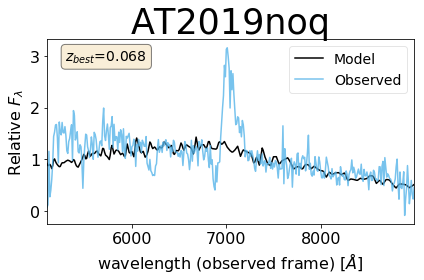

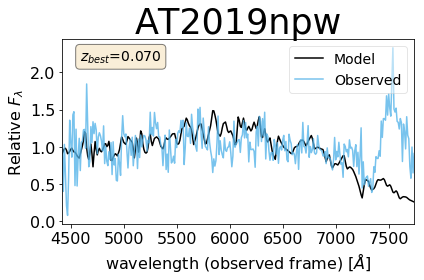

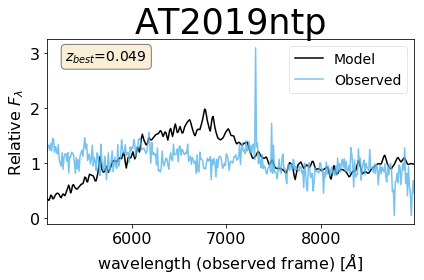

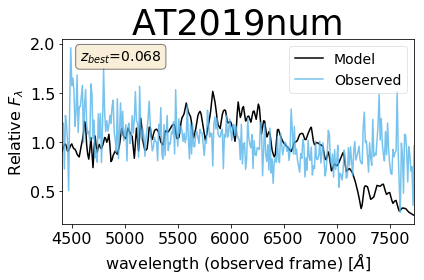

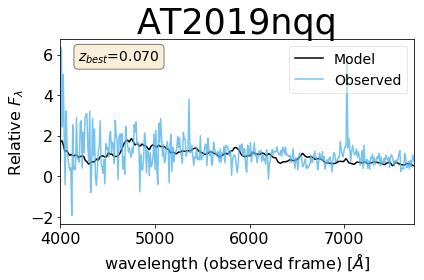

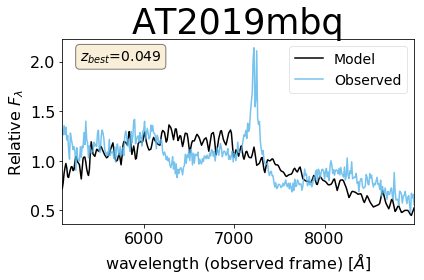

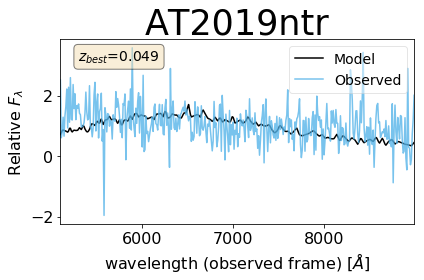

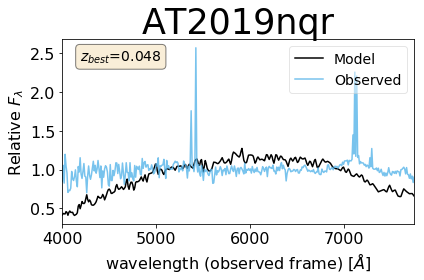

In [5]:
for inputFile_obs in inputFile_obs_list:
    
    fullInputFile_obs = os.path.join(inputFile_obs_dirname, inputFile_obs)
    print 
    print fullInputFile_obs
    
    t = t_dict[inputFile_obs]

    obsname = os.path.basename(inputFile_obs)
    print obsname 
    obsname_clean = cleanName_obs_dict[inputFile_obs]

    
    df_obs = pd.read_csv(fullInputFile_obs, sep='\s+', header = None, names = ['LAMBDA', 'FLUX'])
    
    lambda_lo = df_obs.LAMBDA.min()
    lambda_hi = df_obs.LAMBDA.max()

    wavelength_array = np.arange(lambda_lo, lambda_hi, 10.)

    spec_flux_obs = interpolate.interp1d(df_obs.LAMBDA, df_obs.FLUX,bounds_error=False, fill_value=0.,kind='linear')
    spec_flux_obs_array = spec_flux_obs(wavelength_array)

    df_obs_new = pd.DataFrame({'LAMBDA':wavelength_array, 'FLUX':spec_flux_obs_array})

    norm = df_obs_new['FLUX'].median()
    df_obs['normFLUX'] = df_obs['FLUX']/norm
    df_obs_new['normFLUX'] = df_obs_new['FLUX']/norm

    name, sum2, z_best = fit_to_kasen(kasen_dirname, wavelength_array, df_obs_new, t, z, zerr)
    
    name = os.path.basename(name)
    
    print 
    print "Best fit:  ", name, sum2, z_best
    print 
    
    status = plot_obs_and_bestfit_model(obsname, obsname_clean, kasen_dirname, name, wavelength_array, df_obs_new, t, z_best, sum2, output_dirname)
    
    